[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cozek/hasoc_code/blob/master/notebooks/English/Task%20A%20-%20GPT%202.ipynb)

# If working in colab, clone the repo

In [0]:
import os
import sys

try:
    __import__('google.colab')
    IN_COLAB = True
except:
    IN_COLAB = False

In [0]:
if IN_COLAB:
    os.system('rm -rf /content/hasoc_code/')
    os.system('git clone --recurse-submodules https://github.com/cozek/hasoc_code')
    sys.path.append('/content/hasoc_code/src')
else:
    sys.path.append('../../src')

### Install tranformers

In [0]:
try:
    __import__(transformers)
except:
    os.system("git clone https://github.com/huggingface/transformers")
    os.system("pip install ./transformers")

# Import libraries

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
import collections
from typing import Callable
import numpy as np
import pandas as pd
from tqdm import notebook
import importlib
import pprint
import nltk
import datetime
import os
from argparse import Namespace
import re
from collections import Counter

In [0]:
import utils.general as general_utils
import utils.data as data_utils
import utils.transformer.data as transformer_data_utils
import utils.transformer.general as transformer_general_utils
general_utils.set_seed_everywhere() #set the seed for reproducibility

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
print(torch.__version__)

1.4.0


In [0]:
#from radam import RAdam
#from lookahead import optimizer

In [0]:
from transformers import GPT2Tokenizer, GPT2Model

# Set up the argspace/important_variables

In [0]:
args = Namespace(
        #use cuda by default
        device = 'cuda' if torch.cuda.is_available() else 'cpu',

        #apex
        use_apex = False,

        #model storage
        store_model = True,

        #set batch size and number of epochs
        batch_size = 32,
        num_epochs = 20,
    
        #set the learning rate
        learning_rate = 0.0001,
)

In [0]:
if not IN_COLAB:
    _prefix = '../../'
else : #for colab
    _prefix = '/content/hasoc_code/'
    #location of the train, dev and test csv
args.data_tsv = _prefix + 'data/english_dataset/english_dataset.tsv'
args.test_tsv = _prefix + 'data/english_dataset/hasoc2019_en_test-2919.tsv'
if args.store_model:
     #directory to save our models at
    args.directory = _prefix+'/models/' 
    args.model_name = 'gpt2_eng_a.pt'
    if not os.path.exists(args.directory):
        os.makedirs(args.directory)

In [0]:
if args.use_apex:
    try:
        __import__(apex)
    except:
        print("Installing Nvidia-Apex")
        os.system('export CUDA_HOME=/usr/local/cuda-10.1')
        os.system('git clone https://github.com/NVIDIA/apex')
        os.system('pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex')
        from apex import amp, optimizers

# Load the data tsv for Sub-task A
Sub-task A focus on Hate speech and Offensive language identification offered for English, German, Hindi. Sub-task A is coarse-grained binary classification in which participating system are required to classify tweets into two class, namely: Hate and Offensive (HOF) and Non- Hate and offensive (NOT).

- (NOT) Non Hate-Offensive - This post does not contain any Hate speech, offensive content.
- (HOF) Hate and Offensive - This post contains Hate, offensive, and profane content.

In our annotation, we label a post as HOF if it contains any form of non-acceptable language such as hate speech, aggression, profanity otherwise NOT.

### Load the train set

In [0]:
hasoc_data_df = pd.read_csv(args.data_tsv, sep='\t')
hasoc_data_df_task_a = hasoc_data_df[['text','task_1']]
hasoc_data_df_task_a.columns.values[1] = 'label'
hasoc_data_df_task_a = hasoc_data_df_task_a[hasoc_data_df_task_a.label != 'NONE']
del hasoc_data_df #free memory

In [0]:
task_a_label_dict = {'NOT' :0, 'HOF': 1}

In [0]:
hasoc_data_df_task_a.label = hasoc_data_df_task_a.label.map(task_a_label_dict)

### Train set Samples

In [16]:
hasoc_data_df_task_a.sample(5)

,text,label
3286,#Assange is not a #rapist https://t.co/M4sfW7...,0
2876,#GandiNaaliAbuse | Where an MP says that he wi...,1
2996,"Candle light silent protest in MYSORE, by Myso...",0
23,#ShameOnICC 1. ICC on Dhoni's gloves ...,1
1074,#ICC ...look at pak team...wht is going on.......,0


0    3591
1    2261
Name: label, dtype: int64


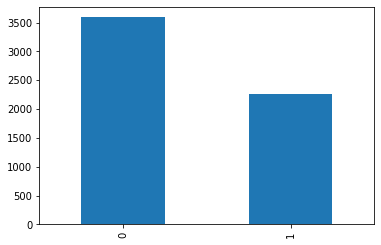

In [17]:
print(hasoc_data_df_task_a.label.value_counts())
hasoc_data_df_task_a.label.value_counts().plot(kind='bar')

### Split dataframe into train and validation

In [0]:
data_df = data_utils.Datasplitter.split_dataframe(hasoc_data_df_task_a, train_frac= 0.9, shuffle=True )

In [19]:
print(data_df.split.value_counts())
sum(data_df.label.value_counts()) == \
sum(data_df[data_df.split == 'train'].label.value_counts())\
 + sum(data_df[data_df.split == 'val'].label.value_counts())

train    5267
val       585
Name: split, dtype: int64


True

In [21]:
hasoc_data_df_task_a.label.value_counts()

0    3591
1    2261
Name: label, dtype: int64

### One-Class Classification using SVM

In [0]:
from sklearn.svm import OneClassSVM
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import sklearn.metrics

### Creating TFIDF vectorizer

In [0]:
hate_text_df =\
 data_df[ (data_df.split == 'train') & (data_df.label == task_a_label_dict['HOF']) ]


In [25]:
hate_text_df

,text,label,split
1539,@realDonaldTrump … says the guy who was instal...,1,train
1116,"He said it again, No Collusion, No obstruction...",1,train
5768,@DonaldJTrumpJr This is rich coming from a dou...,1,train
4036,@AJEnglish Why spend tax $$ for feeding lodgin...,1,train
5694,#JohnMcCainDay Happy John McCain day every...,1,train
...,...,...,...
2632,"Also in #India, #Indian #Sunni #Islamist #poli...",1,train
5647,@The_OJSimpson32 The only shit I hear is what ...,1,train
1077,#HappyBirthdayMrPresident? Nope. GO FUCK YOUR...,1,train
5689,#Army What is this.... Where was ICC then....,1,train


In [0]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(4,4))

In [0]:
hate_tfidf = tfidf_vectorizer.fit_transform(hate_text_df.text)

### Training OneClass SVM

In [0]:
clf = OneClassSVM(gamma='auto').fit(hate_tfidf)

In [0]:
preds = clf.predict(hate_tfidf)

In [50]:
# preds[preds == -1] = 0
collections.Counter(preds)

Counter({-1: 987, 1: 1048})

In [48]:
print(
    classification_report(
            y_true = hate_text_df.label,
            y_pred = preds, 
        )
    )

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.51      0.68      2035

    accuracy                           0.51      2035
   macro avg       0.50      0.26      0.34      2035
weighted avg       1.00      0.51      0.68      2035



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
sklearn.metrics.accuracy_score(
    y_true = hate_text_df.label,
    y_pred = preds, 
)

0.514987714987715

In [64]:
ngram_acc = {}
for n in notebook.tqdm(range(1,51), total = 50):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(n,n))
    hate_tfidf = tfidf_vectorizer.fit_transform(hate_text_df.text)
    clf = OneClassSVM(gamma='auto').fit(hate_tfidf)
    preds = clf.predict(hate_tfidf)
    acc = sklearn.metrics.accuracy_score(
        y_true = hate_text_df.label,
        y_pred = preds, 
    )
    ngram_acc[n] = acc    

In [65]:
ngram_acc

{1: 0.3356265356265356,
 2: 0.7503685503685503,
 3: 0.605896805896806,
 4: 0.514987714987715,
 5: 0.5154791154791155,
 6: 0.5218673218673219,
 7: 0.5316953316953317,
 8: 0.5538083538083538,
 9: 0.576904176904177,
 10: 0.6083538083538084,
 11: 0.6245700245700245,
 12: 0.655036855036855,
 13: 0.682063882063882,
 14: 0.7125307125307125,
 15: 0.7434889434889435,
 16: 0.7764127764127764,
 17: 0.8068796068796069,
 18: 0.8422604422604423,
 19: 0.8737100737100737,
 20: 0.9041769041769042,
 21: 0.9346437346437346,
 22: 0.9695331695331695,
 23: 0.9941031941031941,
 24: 0.5184275184275184,
 25: 0.542997542997543,
 26: 0.5641277641277641,
 27: 0.0,
 28: 0.0,
 29: 0.0,
 30: 0.657985257985258,
 31: 0.6800982800982801,
 32: 0.0,
 33: 0.7100737100737101,
 34: 0.7253071253071253,
 35: 0.7493857493857494,
 36: 0.7695331695331695,
 37: 0.7877149877149877,
 38: 0.0,
 39: 0.831941031941032,
 40: 0.0,
 41: 0.85995085995086,
 42: 0.8781326781326781,
 43: 0.0,
 44: 0.9081081081081082,
 45: 0.0,
 46: 0.0,
 47: